In [22]:
import datetime
import pandas as pd
import yfinance as yf
import numpy as np

In [23]:

# start = datetime.datetime(2016, 1, 1)
# gstock_data=yf.download('TSLA', start)
# gstock_data.head()

In [24]:
# gstock_data.reset_index(inplace=True,drop=False)
# gstock_data

In [25]:
df = pd.read_csv('Stock.csv')
df .head()

,Date,Open,High,Low,Close,Volume
0,2013-01-02,13.601429,13.687143,12.955714,13.144286,19431300
1,2013-01-03,13.138571,13.988571,13.075714,13.798571,27912500
2,2013-01-04,13.791429,13.958571,13.648571,13.711429,17761100
3,2013-01-07,13.770000,14.535714,13.731429,14.171429,45550400
4,2013-01-08,14.287143,14.427143,13.828571,13.880000,24714900


In [26]:
df = df [['Date','Open','Close']] 
df ['Date'] = pd.to_datetime(df ['Date'].apply(lambda x: x.split()[0])) 
df .set_index('Date',drop=True,inplace=True) 
df .head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2602 entries, 2013-01-02 to 2023-05-03
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2602 non-null   float64
 1   Close   2602 non-null   float64
dtypes: float64(2)
memory usage: 61.0 KB


In [27]:
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
df [df .columns] = Ms.fit_transform(df )
training_size = round(len(df ) * 0.80)
train_data = df [:training_size]
test_data  = df [training_size:]

In [28]:
def create_sequence(dataset):
    sequences=[]
    labels=[]
    start_idx=0
    for stop_idx in range(50,len(dataset)):
      sequences.append (dataset.iloc[ start_idx:stop_idx])
      labels.append(dataset.iloc[stop_idx])
      start_idx += 1
    return (np.array(sequences),np.array(labels))  
   

In [29]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)


In [30]:

len(test_seq)

470

In [31]:
np.shape(train_seq)

(2032, 50, 2)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [33]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10600     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
64/64 [==============================] - 5s 32ms/step - loss: 0.0075 - mean_absolute_error: 0.0473 - val_loss: 0.0030 - val_mean_absolute_error: 0.0376
Epoch 2/80
64/64 [==============================] - 1s 22ms/step - loss: 5.9404e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0032 - val_mean_absolute_error: 0.0381
Epoch 3/80
64/64 [==============================] - 1s 21ms/step - loss: 6.1179e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0026 - val_mean_absolute_error: 0.0361
Epoch 4/80
64/64 [==============================] - 1s 21ms/step - loss: 5.7059e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0024 - val_mean_absolute_error: 0.0343
Epoch 5/80
64/64 [==============================] - 1s 21ms/step - loss: 5.3796e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0024 - val_mean_absolute_error: 0.0329
Epoch 6/80
64/64 [==============================] - 1s 21ms/step - loss: 5.4105e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0028 - val_mean_absolute_error: 0.0360
Ep

In [35]:
test_predicted = model.predict(test_seq)
test_inverse_predicted = Ms.inverse_transform(test_predicted)

15/15 [==============================] - 1s 7ms/step


In [36]:
len(test_predicted)

470

In [37]:
merged_data = pd.concat([df .iloc[-(len(test_predicted)):].copy(),pd.DataFrame(test_inverse_predicted,columns=['Open_predicted','Close_predicted'],index=df .iloc[-(len(test_predicted)):].index)], axis=1)

In [38]:
merged_data[['Open','Close']] = Ms.inverse_transform(merged_data[['Open','Close']])
merged_data.head(10)
merged_data.info

<bound method DataFrame.info of                   Open       Close  Open_predicted  Close_predicted
Date                                                               
2021-06-22  498.540009  508.820007      490.551514       496.668274
2021-06-23  508.480011  512.739990      499.396088       504.991180
2021-06-24  517.960022  518.059998      505.078583       510.449127
2021-06-25  528.840027  527.070007      510.014465       515.268738
2021-06-28  528.119995  533.030029      518.088928       523.056458
...                ...         ...             ...              ...
2023-04-27  324.299988  325.850006      316.091400       321.886993
2023-04-28  325.239990  329.929993      318.290222       323.799866
2023-05-01  329.440002  324.119995      322.322083       327.558990
2023-05-02  325.000000  317.549988      320.150269       325.539001
2023-05-03  317.549988  319.744995      313.838867       319.480865

[470 rows x 4 columns]>

In [39]:
merged_data.tail(10)

,Open,Close,Open_predicted,Close_predicted
Date,,,,
2023-04-20,320.390015,325.350006,319.998383,325.951599
2023-04-21,323.000000,327.980011,318.623322,324.410675
2023-04-24,330.200012,329.019989,321.225739,326.747498
2023-04-25,328.500000,322.549988,323.769226,329.187225
2023-04-26,321.359985,321.149994,319.754669,325.455750
2023-04-27,324.299988,325.850006,316.091400,321.886993
2023-04-28,325.239990,329.929993,318.290222,323.799866
2023-05-01,329.440002,324.119995,322.322083,327.558990
2023-05-02,325.000000,317.549988,320.150269,325.539001


In [40]:
import matplotlib.pyplot as plt

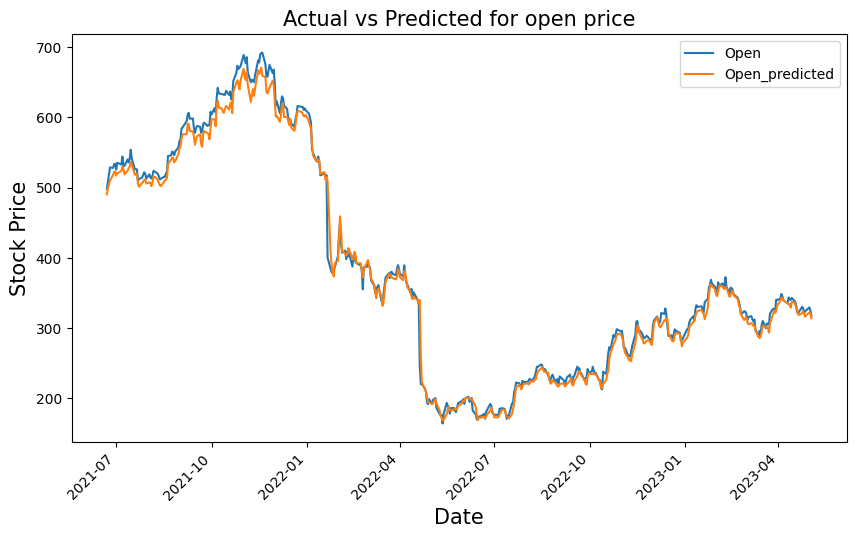

In [41]:
merged_data[['Open','Open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()


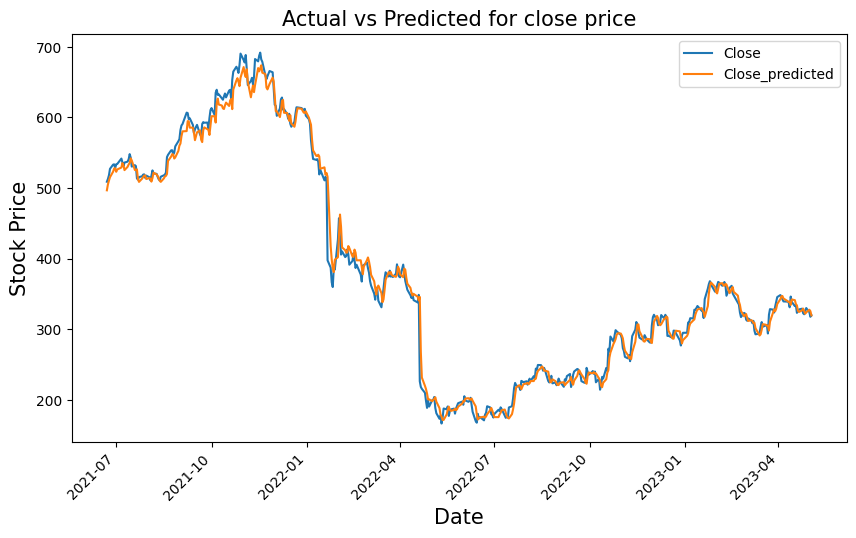

In [42]:
merged_data[['Close','Close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()
